In [35]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.spatial import Delaunay
import folium as f

g_pickle = "data/02_cambridge.gpickle"
g = nx.read_gpickle(g_pickle)
arbitrary_sub_g = random.sample(g.nodes().data(), 10) 
node_ids = [node[1]['id'] for node in arbitrary_sub_g]

# Use triangulation to create subgraph

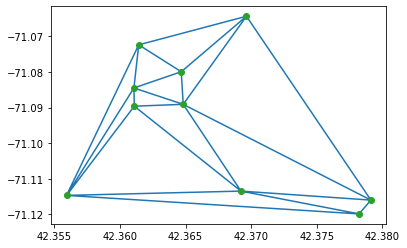

In [36]:
arbitrary_sub_g = random.sample(g.nodes().data(), 10) 
node_ids = [node[1]['id'] for node in arbitrary_sub_g]

points = []
for node in node_ids:
    node = g.nodes()[node] 
    lat, lon = node['lat'], node['lon']
    points.append([lat, lon])

points = np.array(points)
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [37]:
def edges_from_simplex(tri):
    edges = [] 
    points = tri.points
    for simplex in tri.simplices:
        a = points[(simplex[0])].tolist()
        b = points[simplex[1]].tolist()
        c = points[simplex[2]].tolist()
        edges.append([a,b])
        edges.append([b,c])
        edges.append([c,a])
    
    return_edges = []
    for edge in edges:
        if edge not in return_edges and [edge[1], edge[0]] not in return_edges:
            return_edges.append(edge)
    return return_edges

edges = edges_from_simplex(tri)

edges

[[[42.3696426, -71.0643716], [42.3648191, -71.0891001]],
 [[42.3648191, -71.0891001], [42.3791349, -71.1159802]],
 [[42.3791349, -71.1159802], [42.3696426, -71.0643716]],
 [[42.3648191, -71.0891001], [42.369224, -71.113454]],
 [[42.369224, -71.113454], [42.3791349, -71.1159802]],
 [[42.3782301, -71.119859], [42.369224, -71.113454]],
 [[42.369224, -71.113454], [42.3559215, -71.1146594]],
 [[42.3559215, -71.1146594], [42.3782301, -71.119859]],
 [[42.3782301, -71.119859], [42.3791349, -71.1159802]],
 [[42.369224, -71.113454], [42.3610899, -71.0896177]],
 [[42.3610899, -71.0896177], [42.3559215, -71.1146594]],
 [[42.3648191, -71.0891001], [42.3610899, -71.0896177]],
 [[42.364671, -71.0799517], [42.3648191, -71.0891001]],
 [[42.3696426, -71.0643716], [42.364671, -71.0799517]],
 [[42.3614277, -71.0723979], [42.364671, -71.0799517]],
 [[42.3696426, -71.0643716], [42.3614277, -71.0723979]],
 [[42.3610599, -71.0845044], [42.364671, -71.0799517]],
 [[42.3614277, -71.0723979], [42.3610599, -71.08

In [38]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])

In [39]:
walks = []

for edge1 in edges:
    for edge2 in edges:
        if edge1 == edge2: 
            continue
        elif edge1[0] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[0]],
                          "dest": edge2[1]})
        elif edge1[0] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})
        elif edge1[1] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                           "source": edge1[0],
                           "inter": edge2[0],
                           "dest": edge2[1]})
        elif edge1[1] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[0],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})

In [40]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])
        
def dist_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path_length(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


In [41]:
edges_to_eliminate = []

# The lower this number (between 0 and 1), the more lines eliminated
ELIMINATION_CUTOFF = .8


count = 0

for walk in walks:
    count+=1
    if count % 13 == 0: print( str(count) + " / " + str(len(walks)))
    
    BAD_DATA = False
    straight_distance = dist_by_edge((walk.get('source'), walk.get('dest')))
    if straight_distance is None: 
        BAD_DATA = True
        continue
    roundabout_distance = 0
    for edge in walk.get('walk'):  
        edge_dist = dist_by_edge(edge)
        if edge_dist is None: 
            BAD_DATA = True
            continue
        roundabout_distance += dist_by_edge(edge)
    if BAD_DATA: continue
    if (roundabout_distance * ELIMINATION_CUTOFF < straight_distance):
        edges_to_eliminate.append((node_id_from_latlon(walk.get('source')), node_id_from_latlon(walk.get('dest'))))

13 / 156
26 / 156
39 / 156
52 / 156
65 / 156
78 / 156
91 / 156
104 / 156
117 / 156
130 / 156
143 / 156
156 / 156


In [42]:
final_edges = []

for edge in edges:
    is_eliminated = False
    
    source, dest = edge
    source_id = node_id_from_latlon(source)
    dest_id = node_id_from_latlon(dest)
    for edge_to_elim in edges_to_eliminate:
        if (source_id, dest_id) == edge_to_elim:
            is_eliminated = True
            continue
    if not is_eliminated:
        final_edges.append(edge)
        
print ((str (len(edges) - len(final_edges))) + " lines removed out of " + str(len(edges)) + ". Too few? Too many? Change ELIMINATION_CUTOFF.")

5 lines removed out of 22. Too few? Too many? Change ELIMINATION_CUTOFF.


# Map of subgraph. If you don't like what you see, change ELIMINATION_CUTOFF

In [43]:
def shortest_path_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


m = f.Map(location = [42.3611108,-71.119977], zoom_start=14)
for final_edge in final_edges:
    short_path_edges = shortest_path_by_edge(final_edge)
    if short_path_edges is None: continue
    
    line_locations = [[g.nodes()[n_id]['lat'], g.nodes()[n_id]['lon']] for n_id in short_path_edges]
    m.add_child(f.PolyLine(locations=line_locations, line_opacity=1, color="green"))

display_nums = {}
num = 50
for node_id in node_ids:
    num += 1
    display_nums[node_id] = num

for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    lon,lat = node_data[1]['lon'], node_data[1]['lat'] 
    
    if node_id in node_ids:
        size = 25
        display_num = 4
#         m.add_child(f.CircleMarker(location=[lat,lon], color="blue", radius=2, tooltip=node_id))
        f.Marker(location=[lat,lon],
                  # Set icon to DivIcon to with conditional style formatting to reference the random temp value.
                  icon=f.DivIcon(html=f"""<div style="border:1px solid green; text-align: center; vertical-align: middle; line-height: {size}px; background-color: white; width: {size}px; height: {size}px; border-radius: {size}px; font-family: sans-serif; color: green;">{display_nums[node_id]}</div>""")
                 ).add_to(m)
m

## Cruft Zone

In [11]:
local_maxima_nodes = []

count = 0
len_g = len(g)
for node in g.nodes():
    print(str(count) + " / " + str(len_g))
    count += 1
    weight = g.nodes()[node].get('adjusted_weight', 0)
    if weight == 0: 
        continue
    weight = weight - .0000000000000001
    weight_list = [weight]
    neighbors = list(nx.all_neighbors(g, node))
    if len(neighbors) == 2:
        continue
    for neighbor in neighbors:
        weight_list.append(g.nodes()[neighbor].get('adjusted_weight', 0))
        neighbors2 = list(nx.all_neighbors(g, neighbor))
        for neighbor2 in neighbors2:
            if neighbor2 != node:
                weight_list.append(g.nodes()[neighbor2].get('adjusted_weight', 0))
    if max(weight_list) == weight and len(weight_list):
        local_maxima_nodes.append(node)
        print(weight_list)
    
local_maxima_nodes

0 / 21438
1 / 21438
2 / 21438
3 / 21438
4 / 21438
5 / 21438
6 / 21438
7 / 21438
8 / 21438
9 / 21438
10 / 21438
11 / 21438
12 / 21438
13 / 21438
14 / 21438
15 / 21438
16 / 21438
17 / 21438
18 / 21438
19 / 21438
20 / 21438
21 / 21438
22 / 21438
23 / 21438
24 / 21438
25 / 21438
26 / 21438
27 / 21438
28 / 21438
29 / 21438
30 / 21438
31 / 21438
32 / 21438
33 / 21438
34 / 21438
35 / 21438
36 / 21438
37 / 21438
38 / 21438
39 / 21438
40 / 21438
41 / 21438
42 / 21438
43 / 21438
44 / 21438
45 / 21438
46 / 21438
47 / 21438
48 / 21438
49 / 21438
50 / 21438
51 / 21438
52 / 21438
53 / 21438
54 / 21438
55 / 21438
56 / 21438
57 / 21438
58 / 21438
59 / 21438
60 / 21438
61 / 21438
62 / 21438
63 / 21438
64 / 21438
65 / 21438
66 / 21438
67 / 21438
68 / 21438
69 / 21438
70 / 21438
71 / 21438
72 / 21438
73 / 21438
74 / 21438
75 / 21438
76 / 21438
77 / 21438
78 / 21438
79 / 21438
80 / 21438
81 / 21438
82 / 21438
83 / 21438
84 / 21438
85 / 21438
86 / 21438
87 / 21438
88 / 21438
89 / 21438
90 / 21438
91 / 2143

1408 / 21438
1409 / 21438
1410 / 21438
1411 / 21438
1412 / 21438
1413 / 21438
1414 / 21438
1415 / 21438
1416 / 21438
1417 / 21438
1418 / 21438
1419 / 21438
1420 / 21438
1421 / 21438
1422 / 21438
1423 / 21438
1424 / 21438
1425 / 21438
1426 / 21438
1427 / 21438
1428 / 21438
1429 / 21438
1430 / 21438
1431 / 21438
1432 / 21438
1433 / 21438
1434 / 21438
1435 / 21438
1436 / 21438
1437 / 21438
1438 / 21438
1439 / 21438
1440 / 21438
1441 / 21438
1442 / 21438
1443 / 21438
1444 / 21438
1445 / 21438
1446 / 21438
1447 / 21438
1448 / 21438
1449 / 21438
1450 / 21438
1451 / 21438
1452 / 21438
1453 / 21438
1454 / 21438
1455 / 21438
1456 / 21438
1457 / 21438
1458 / 21438
1459 / 21438
1460 / 21438
1461 / 21438
1462 / 21438
1463 / 21438
1464 / 21438
1465 / 21438
1466 / 21438
1467 / 21438
1468 / 21438
1469 / 21438
1470 / 21438
1471 / 21438
1472 / 21438
1473 / 21438
1474 / 21438
1475 / 21438
1476 / 21438
1477 / 21438
1478 / 21438
1479 / 21438
1480 / 21438
1481 / 21438
1482 / 21438
1483 / 21438
1484 / 21438

2564 / 21438
2565 / 21438
2566 / 21438
2567 / 21438
2568 / 21438
2569 / 21438
2570 / 21438
2571 / 21438
2572 / 21438
2573 / 21438
2574 / 21438
2575 / 21438
2576 / 21438
2577 / 21438
2578 / 21438
2579 / 21438
2580 / 21438
2581 / 21438
2582 / 21438
2583 / 21438
2584 / 21438
2585 / 21438
2586 / 21438
2587 / 21438
2588 / 21438
2589 / 21438
2590 / 21438
2591 / 21438
2592 / 21438
2593 / 21438
2594 / 21438
2595 / 21438
2596 / 21438
2597 / 21438
2598 / 21438
2599 / 21438
2600 / 21438
2601 / 21438
2602 / 21438
2603 / 21438
2604 / 21438
2605 / 21438
2606 / 21438
2607 / 21438
2608 / 21438
2609 / 21438
2610 / 21438
2611 / 21438
2612 / 21438
2613 / 21438
2614 / 21438
2615 / 21438
2616 / 21438
2617 / 21438
2618 / 21438
2619 / 21438
2620 / 21438
2621 / 21438
2622 / 21438
2623 / 21438
2624 / 21438
2625 / 21438
2626 / 21438
2627 / 21438
2628 / 21438
2629 / 21438
2630 / 21438
2631 / 21438
2632 / 21438
2633 / 21438
2634 / 21438
2635 / 21438
2636 / 21438
2637 / 21438
2638 / 21438
2639 / 21438
2640 / 21438

3907 / 21438
3908 / 21438
3909 / 21438
3910 / 21438
3911 / 21438
3912 / 21438
3913 / 21438
3914 / 21438
3915 / 21438
3916 / 21438
3917 / 21438
3918 / 21438
3919 / 21438
3920 / 21438
3921 / 21438
3922 / 21438
3923 / 21438
3924 / 21438
3925 / 21438
3926 / 21438
3927 / 21438
3928 / 21438
3929 / 21438
3930 / 21438
3931 / 21438
3932 / 21438
3933 / 21438
3934 / 21438
3935 / 21438
3936 / 21438
3937 / 21438
3938 / 21438
3939 / 21438
3940 / 21438
3941 / 21438
3942 / 21438
3943 / 21438
3944 / 21438
3945 / 21438
3946 / 21438
3947 / 21438
3948 / 21438
3949 / 21438
3950 / 21438
3951 / 21438
3952 / 21438
3953 / 21438
3954 / 21438
3955 / 21438
3956 / 21438
3957 / 21438
3958 / 21438
3959 / 21438
3960 / 21438
3961 / 21438
3962 / 21438
3963 / 21438
3964 / 21438
3965 / 21438
3966 / 21438
3967 / 21438
3968 / 21438
3969 / 21438
3970 / 21438
3971 / 21438
3972 / 21438
3973 / 21438
3974 / 21438
3975 / 21438
3976 / 21438
3977 / 21438
3978 / 21438
3979 / 21438
3980 / 21438
3981 / 21438
3982 / 21438
3983 / 21438

5406 / 21438
5407 / 21438
5408 / 21438
5409 / 21438
5410 / 21438
5411 / 21438
5412 / 21438
5413 / 21438
5414 / 21438
5415 / 21438
5416 / 21438
5417 / 21438
5418 / 21438
5419 / 21438
5420 / 21438
5421 / 21438
5422 / 21438
5423 / 21438
5424 / 21438
5425 / 21438
5426 / 21438
5427 / 21438
5428 / 21438
5429 / 21438
5430 / 21438
5431 / 21438
5432 / 21438
5433 / 21438
5434 / 21438
5435 / 21438
5436 / 21438
5437 / 21438
5438 / 21438
5439 / 21438
5440 / 21438
5441 / 21438
5442 / 21438
5443 / 21438
5444 / 21438
5445 / 21438
5446 / 21438
5447 / 21438
5448 / 21438
5449 / 21438
5450 / 21438
5451 / 21438
5452 / 21438
5453 / 21438
5454 / 21438
5455 / 21438
5456 / 21438
5457 / 21438
5458 / 21438
5459 / 21438
5460 / 21438
5461 / 21438
5462 / 21438
5463 / 21438
5464 / 21438
5465 / 21438
5466 / 21438
5467 / 21438
5468 / 21438
5469 / 21438
5470 / 21438
5471 / 21438
5472 / 21438
5473 / 21438
5474 / 21438
5475 / 21438
5476 / 21438
5477 / 21438
5478 / 21438
5479 / 21438
5480 / 21438
5481 / 21438
5482 / 21438

6906 / 21438
6907 / 21438
6908 / 21438
6909 / 21438
6910 / 21438
6911 / 21438
6912 / 21438
6913 / 21438
6914 / 21438
6915 / 21438
6916 / 21438
6917 / 21438
6918 / 21438
6919 / 21438
6920 / 21438
6921 / 21438
6922 / 21438
6923 / 21438
6924 / 21438
6925 / 21438
6926 / 21438
6927 / 21438
6928 / 21438
6929 / 21438
6930 / 21438
6931 / 21438
6932 / 21438
6933 / 21438
6934 / 21438
6935 / 21438
6936 / 21438
6937 / 21438
6938 / 21438
6939 / 21438
6940 / 21438
6941 / 21438
6942 / 21438
6943 / 21438
6944 / 21438
6945 / 21438
6946 / 21438
6947 / 21438
6948 / 21438
6949 / 21438
6950 / 21438
6951 / 21438
6952 / 21438
6953 / 21438
6954 / 21438
6955 / 21438
6956 / 21438
6957 / 21438
6958 / 21438
6959 / 21438
6960 / 21438
6961 / 21438
6962 / 21438
6963 / 21438
6964 / 21438
6965 / 21438
6966 / 21438
6967 / 21438
6968 / 21438
6969 / 21438
6970 / 21438
6971 / 21438
6972 / 21438
6973 / 21438
6974 / 21438
6975 / 21438
6976 / 21438
6977 / 21438
6978 / 21438
6979 / 21438
6980 / 21438
6981 / 21438
6982 / 21438

8405 / 21438
8406 / 21438
8407 / 21438
8408 / 21438
8409 / 21438
8410 / 21438
8411 / 21438
8412 / 21438
8413 / 21438
8414 / 21438
8415 / 21438
8416 / 21438
8417 / 21438
8418 / 21438
8419 / 21438
8420 / 21438
8421 / 21438
8422 / 21438
8423 / 21438
8424 / 21438
8425 / 21438
8426 / 21438
8427 / 21438
8428 / 21438
8429 / 21438
8430 / 21438
8431 / 21438
8432 / 21438
8433 / 21438
8434 / 21438
8435 / 21438
8436 / 21438
8437 / 21438
8438 / 21438
8439 / 21438
8440 / 21438
8441 / 21438
8442 / 21438
8443 / 21438
8444 / 21438
8445 / 21438
8446 / 21438
8447 / 21438
8448 / 21438
8449 / 21438
8450 / 21438
8451 / 21438
8452 / 21438
8453 / 21438
8454 / 21438
8455 / 21438
8456 / 21438
8457 / 21438
8458 / 21438
8459 / 21438
8460 / 21438
8461 / 21438
8462 / 21438
8463 / 21438
8464 / 21438
8465 / 21438
8466 / 21438
8467 / 21438
8468 / 21438
8469 / 21438
8470 / 21438
8471 / 21438
8472 / 21438
8473 / 21438
8474 / 21438
8475 / 21438
8476 / 21438
8477 / 21438
8478 / 21438
8479 / 21438
8480 / 21438
8481 / 21438

9905 / 21438
9906 / 21438
9907 / 21438
9908 / 21438
9909 / 21438
9910 / 21438
9911 / 21438
9912 / 21438
9913 / 21438
9914 / 21438
9915 / 21438
9916 / 21438
9917 / 21438
9918 / 21438
9919 / 21438
9920 / 21438
9921 / 21438
9922 / 21438
9923 / 21438
9924 / 21438
9925 / 21438
9926 / 21438
9927 / 21438
9928 / 21438
9929 / 21438
9930 / 21438
9931 / 21438
9932 / 21438
9933 / 21438
9934 / 21438
9935 / 21438
9936 / 21438
9937 / 21438
9938 / 21438
9939 / 21438
9940 / 21438
9941 / 21438
9942 / 21438
9943 / 21438
9944 / 21438
9945 / 21438
9946 / 21438
9947 / 21438
9948 / 21438
9949 / 21438
9950 / 21438
9951 / 21438
9952 / 21438
9953 / 21438
9954 / 21438
9955 / 21438
9956 / 21438
9957 / 21438
9958 / 21438
9959 / 21438
9960 / 21438
9961 / 21438
9962 / 21438
9963 / 21438
9964 / 21438
9965 / 21438
9966 / 21438
9967 / 21438
9968 / 21438
9969 / 21438
9970 / 21438
9971 / 21438
9972 / 21438
9973 / 21438
9974 / 21438
9975 / 21438
9976 / 21438
9977 / 21438
9978 / 21438
9979 / 21438
9980 / 21438
9981 / 21438

11404 / 21438
11405 / 21438
11406 / 21438
11407 / 21438
11408 / 21438
11409 / 21438
11410 / 21438
11411 / 21438
11412 / 21438
11413 / 21438
11414 / 21438
11415 / 21438
11416 / 21438
11417 / 21438
11418 / 21438
11419 / 21438
11420 / 21438
11421 / 21438
11422 / 21438
11423 / 21438
11424 / 21438
11425 / 21438
11426 / 21438
11427 / 21438
11428 / 21438
11429 / 21438
11430 / 21438
11431 / 21438
11432 / 21438
11433 / 21438
11434 / 21438
11435 / 21438
11436 / 21438
11437 / 21438
11438 / 21438
11439 / 21438
11440 / 21438
11441 / 21438
11442 / 21438
11443 / 21438
11444 / 21438
11445 / 21438
11446 / 21438
11447 / 21438
11448 / 21438
11449 / 21438
11450 / 21438
11451 / 21438
11452 / 21438
11453 / 21438
11454 / 21438
11455 / 21438
11456 / 21438
11457 / 21438
11458 / 21438
11459 / 21438
11460 / 21438
11461 / 21438
11462 / 21438
11463 / 21438
11464 / 21438
11465 / 21438
11466 / 21438
11467 / 21438
11468 / 21438
11469 / 21438
11470 / 21438
11471 / 21438
11472 / 21438
11473 / 21438
11474 / 21438
11475 

12904 / 21438
12905 / 21438
12906 / 21438
12907 / 21438
12908 / 21438
12909 / 21438
12910 / 21438
12911 / 21438
12912 / 21438
12913 / 21438
12914 / 21438
12915 / 21438
12916 / 21438
12917 / 21438
12918 / 21438
12919 / 21438
12920 / 21438
12921 / 21438
12922 / 21438
12923 / 21438
12924 / 21438
12925 / 21438
12926 / 21438
12927 / 21438
12928 / 21438
12929 / 21438
12930 / 21438
12931 / 21438
12932 / 21438
12933 / 21438
12934 / 21438
12935 / 21438
12936 / 21438
12937 / 21438
12938 / 21438
12939 / 21438
12940 / 21438
12941 / 21438
12942 / 21438
12943 / 21438
12944 / 21438
12945 / 21438
12946 / 21438
12947 / 21438
12948 / 21438
12949 / 21438
12950 / 21438
12951 / 21438
12952 / 21438
12953 / 21438
12954 / 21438
12955 / 21438
12956 / 21438
12957 / 21438
12958 / 21438
12959 / 21438
12960 / 21438
12961 / 21438
12962 / 21438
12963 / 21438
12964 / 21438
12965 / 21438
12966 / 21438
12967 / 21438
12968 / 21438
12969 / 21438
12970 / 21438
12971 / 21438
12972 / 21438
12973 / 21438
12974 / 21438
12975 

14403 / 21438
14404 / 21438
14405 / 21438
14406 / 21438
14407 / 21438
14408 / 21438
14409 / 21438
14410 / 21438
14411 / 21438
14412 / 21438
14413 / 21438
14414 / 21438
14415 / 21438
14416 / 21438
14417 / 21438
14418 / 21438
14419 / 21438
14420 / 21438
14421 / 21438
14422 / 21438
14423 / 21438
14424 / 21438
14425 / 21438
14426 / 21438
14427 / 21438
14428 / 21438
14429 / 21438
14430 / 21438
14431 / 21438
14432 / 21438
14433 / 21438
14434 / 21438
14435 / 21438
14436 / 21438
14437 / 21438
14438 / 21438
14439 / 21438
14440 / 21438
14441 / 21438
14442 / 21438
14443 / 21438
14444 / 21438
14445 / 21438
14446 / 21438
14447 / 21438
14448 / 21438
14449 / 21438
14450 / 21438
14451 / 21438
14452 / 21438
14453 / 21438
14454 / 21438
14455 / 21438
14456 / 21438
14457 / 21438
14458 / 21438
14459 / 21438
14460 / 21438
14461 / 21438
14462 / 21438
14463 / 21438
14464 / 21438
14465 / 21438
14466 / 21438
14467 / 21438
14468 / 21438
14469 / 21438
14470 / 21438
14471 / 21438
14472 / 21438
14473 / 21438
14474 

15903 / 21438
15904 / 21438
15905 / 21438
15906 / 21438
15907 / 21438
15908 / 21438
15909 / 21438
15910 / 21438
15911 / 21438
15912 / 21438
15913 / 21438
15914 / 21438
15915 / 21438
15916 / 21438
15917 / 21438
15918 / 21438
15919 / 21438
15920 / 21438
15921 / 21438
15922 / 21438
15923 / 21438
15924 / 21438
15925 / 21438
15926 / 21438
15927 / 21438
15928 / 21438
15929 / 21438
15930 / 21438
15931 / 21438
15932 / 21438
15933 / 21438
15934 / 21438
15935 / 21438
15936 / 21438
15937 / 21438
15938 / 21438
15939 / 21438
15940 / 21438
15941 / 21438
15942 / 21438
15943 / 21438
15944 / 21438
15945 / 21438
15946 / 21438
15947 / 21438
15948 / 21438
15949 / 21438
15950 / 21438
15951 / 21438
15952 / 21438
15953 / 21438
15954 / 21438
15955 / 21438
15956 / 21438
15957 / 21438
15958 / 21438
15959 / 21438
15960 / 21438
15961 / 21438
15962 / 21438
15963 / 21438
15964 / 21438
15965 / 21438
15966 / 21438
15967 / 21438
15968 / 21438
15969 / 21438
15970 / 21438
15971 / 21438
15972 / 21438
15973 / 21438
15974 

17402 / 21438
17403 / 21438
17404 / 21438
17405 / 21438
17406 / 21438
17407 / 21438
17408 / 21438
17409 / 21438
17410 / 21438
17411 / 21438
17412 / 21438
17413 / 21438
17414 / 21438
17415 / 21438
17416 / 21438
17417 / 21438
17418 / 21438
17419 / 21438
17420 / 21438
17421 / 21438
17422 / 21438
17423 / 21438
17424 / 21438
17425 / 21438
17426 / 21438
17427 / 21438
17428 / 21438
17429 / 21438
17430 / 21438
17431 / 21438
17432 / 21438
17433 / 21438
17434 / 21438
17435 / 21438
17436 / 21438
17437 / 21438
17438 / 21438
17439 / 21438
17440 / 21438
17441 / 21438
17442 / 21438
17443 / 21438
17444 / 21438
17445 / 21438
17446 / 21438
17447 / 21438
17448 / 21438
17449 / 21438
17450 / 21438
17451 / 21438
17452 / 21438
17453 / 21438
17454 / 21438
17455 / 21438
17456 / 21438
17457 / 21438
17458 / 21438
17459 / 21438
17460 / 21438
17461 / 21438
17462 / 21438
17463 / 21438
17464 / 21438
17465 / 21438
17466 / 21438
17467 / 21438
17468 / 21438
17469 / 21438
17470 / 21438
17471 / 21438
17472 / 21438
17473 

18902 / 21438
18903 / 21438
18904 / 21438
18905 / 21438
18906 / 21438
18907 / 21438
18908 / 21438
18909 / 21438
18910 / 21438
18911 / 21438
18912 / 21438
18913 / 21438
18914 / 21438
18915 / 21438
18916 / 21438
18917 / 21438
18918 / 21438
18919 / 21438
18920 / 21438
18921 / 21438
18922 / 21438
18923 / 21438
18924 / 21438
18925 / 21438
18926 / 21438
18927 / 21438
18928 / 21438
18929 / 21438
18930 / 21438
18931 / 21438
18932 / 21438
18933 / 21438
18934 / 21438
18935 / 21438
18936 / 21438
18937 / 21438
18938 / 21438
18939 / 21438
18940 / 21438
18941 / 21438
18942 / 21438
18943 / 21438
18944 / 21438
18945 / 21438
18946 / 21438
18947 / 21438
18948 / 21438
18949 / 21438
18950 / 21438
18951 / 21438
18952 / 21438
18953 / 21438
18954 / 21438
18955 / 21438
18956 / 21438
18957 / 21438
18958 / 21438
18959 / 21438
18960 / 21438
18961 / 21438
18962 / 21438
18963 / 21438
18964 / 21438
18965 / 21438
18966 / 21438
18967 / 21438
18968 / 21438
18969 / 21438
18970 / 21438
18971 / 21438
18972 / 21438
18973 

20401 / 21438
20402 / 21438
20403 / 21438
20404 / 21438
20405 / 21438
20406 / 21438
20407 / 21438
20408 / 21438
20409 / 21438
20410 / 21438
20411 / 21438
20412 / 21438
20413 / 21438
20414 / 21438
20415 / 21438
20416 / 21438
20417 / 21438
20418 / 21438
20419 / 21438
20420 / 21438
20421 / 21438
20422 / 21438
20423 / 21438
20424 / 21438
20425 / 21438
20426 / 21438
20427 / 21438
20428 / 21438
20429 / 21438
20430 / 21438
20431 / 21438
20432 / 21438
20433 / 21438
20434 / 21438
20435 / 21438
20436 / 21438
20437 / 21438
20438 / 21438
20439 / 21438
20440 / 21438
20441 / 21438
20442 / 21438
20443 / 21438
20444 / 21438
20445 / 21438
20446 / 21438
20447 / 21438
20448 / 21438
20449 / 21438
20450 / 21438
20451 / 21438
20452 / 21438
20453 / 21438
20454 / 21438
20455 / 21438
20456 / 21438
20457 / 21438
20458 / 21438
20459 / 21438
20460 / 21438
20461 / 21438
20462 / 21438
20463 / 21438
20464 / 21438
20465 / 21438
20466 / 21438
20467 / 21438
20468 / 21438
20469 / 21438
20470 / 21438
20471 / 21438
20472 

[]

In [12]:
len(local_maxima_nodes)

0